# Modeling LLM-Query Serving Systems Through Simulation
Yik Hau Au (ya293), Kimberly Bond (klb298), Dionisius Tjajono (dt565),
Ryan Weigle (rhw228), Sadie Roecker (sdr83)

ORIE 4580/5580 - Simulation Modeling and Analysis



## Executive Summary

Large language model (LLM) inference systems must balance low user-facing latency with efficient utilization of expensive GPU resources. Unlike training workloads, inference serves queries that arrive over time and must return responses incrementally as tokens, making metrics such as Time to First Token (TTFT) and Time Between Tokens (TBT) central to user experience. The asymmetric structure of LLM inference—consisting of a compute-intensive prefill phase followed by a lighter, sequential decode phase—creates fundamental trade-offs between latency and throughput that are strongly influenced by scheduling and batching decisions.

This project develops a stochastic discrete-event simulation of an LLM-serving system to study these trade-offs in a controlled and interpretable setting. Rather than comparing different model architectures, the simulation fixes the underlying LLM and focuses on system-level behavior. The model captures stochastic query arrivals, per-query progression through prefill and decode, batch formation rules, GPU service-time physics, and centralized scheduling. Performance is evaluated using throughput, TTFT, TBT, tail latency, and GPU utilization.

We evaluate three classes of experiments: a baseline single-GPU system with run-to-completion scheduling, advanced scheduling with prefill-prioritizing batching, and multi-GPU configurations to study scalability. Results show that run-to-completion scheduling provides smooth decoding but suffers from severe head-of-line blocking, leading to high and variable TTFT under load. Prefill-prioritizing batching mitigates this issue by amortizing setup costs and reducing queueing delays, improving throughput by approximately 30 percent on a single GPU while reducing mean TTFT. However, batching introduces modest increases in TBT and can worsen tail latency when batch sizes become too large.

Multi-GPU simulations demonstrate that scaling hardware increases capacity and reduces latency at moderate load, but does not eliminate scheduling trade-offs. While parallelism reduces head-of-line blocking, queueing and tail latency re-emerge near saturation, and batching decisions continue to significantly affect performance. Across both single- and multi-GPU systems, small batch sizes capture most efficiency gains, while large batches primarily increase tail latency and reduce fairness.

Overall, the results show that hardware scaling and scheduling are complementary, not interchangeable. Effective LLM-serving systems require carefully tuned scheduling and batching policies in addition to sufficient compute resources. This study demonstrates the value of simulation for reasoning about LLM inference systems and provides concrete guidance for designing schedulers that balance responsiveness, throughput, and fairness at scale.


## Introduction and Motivation

Modern large-language model (LLM) inference is the process through which these models process queries and output understandable text in real-time. While similar to training, the process through which model logic is developed on large static datasets, LLM inference must service user prompts arriving over time and deliver responses in increments, or tokens. This makes user-facing latency the most important concern when assessing LLM inference.

When an LLM is sent a prompt, that prompt undergoes two asymmetric phases in order for a response to be returned to the user. The first is the prefill phase, in which the model reads the prompt and prepares to deliver the first token of response. This step is computation-intensive, utilizes more GPU resources, and has high latency per iteration. The second is the decode phase, where the model generates the response back to the user one token at a time until the output is complete. This step uses significantly less GPU resources and has less latency per iteration, making it ideal for batching across queries.

The asymmetry of these steps means that how the system schedules queries is a major concern. Prioritizing decode steps through aggressive batching can improve throughput but may inflate the time to first token (TTFT), while prioritizing prefill may increase time between tokens (TBT). Thus, we want to find a scheduling logic that balances these three metrics for optimal user experience. To accomplish this, our team developed a simulation-based model to capture and analyze the effects of batching and different scheduler configurations.

Throughout our analysis, we look to answer three research questions, how batching and scheduling policies affect throughput and latency, where trade-offs between TTFT and TBT emerge, and what conditions aggressive batching affects user experience negatively.

## System Overview and Modeling Assumptions

Our simulation models an LLM inference system at a high level, maintaining only the most essential components that influence throughput, TTFT, and TBT. The system is composed of an input queue, a scheduler, and one or more GPU workers. As queries arrive over time, they are placed in the input queue where they await processing. The scheduler then decides when and how to group queries into batches and then how to distribute these batches to available GPU workers.

Once a query is sent to a GPU worker, it enters the prefill phase, processing the entire prompt. Once prefill is complete, the query moves to the decode phase, where output tokens are generated one at a time. The query then exits the system once its output token budget has been reached.

Our team made several assumptions to keep the model accurate and interpretable. Query arrivals occur according to a Poisson process with rate λ, meaning interarrival times are exponentially distributed. This is a common assumption for capturing random user behavior and assists in validation of the model. Each job i has a fixed prompt length $L_i$ and output budget $B_i$, so that there are proper token bounds in place. Finally, GPUs are assumed to be homogenous, meaning each is capable of processing one batch at a time with identical service. These assumptions help simplify the model but preserve the most important performance indicators for scheduling and batching. This way, we can connect our model to queueing theory for validation while still getting relevant information for LLM inference.


## Arrival process and Workload Characterization

Arrivals are generated using exponentially distributed interarrival times with rate λ. Arrival times are precomputed and stored, and all arrivals with timestamp less than or equal to the current simulation clock are admitted into the system. Each arriving query is assigned a prompt length $L_i$ and an output budget $B_i$. In baseline experiments, these values are fixed across queries to isolate scheduling effects. Sensitivity experiments vary $L_i$, $B_i$, and λ independently. Prompt length and output budget are treated as independent random variables.


##GPU Service Time Model

GPUs are modeled as batch-processing servers. When a GPU begins processing a batch, all jobs in the batch begin and end simultaneously. The service time of a batch depends on the total number of tokens in the batch and is given by
$$S(b) = C + a*max(0, b-b_0).$$


Here, C represents a fixed setup cost, a represents a marginal per-token cost, and $b_0$ is a threshold below which only setup cost applies. In the simulation, C and a are sampled independently from exponential distributions with specified means, introducing stochastic variability while preserving the expected piecewise-linear structure. This service model is shared across all scheduling policies to isolate the effect of scheduling decisions.



## Scheduling and Batching Policies

The baseline scheduler follows a run-to-completion policy with no batching. Each query executes its entire prefill phase alone, followed by sequential decoding where each token is generated in a separate GPU operation. This policy minimizes interference during decode but is vulnerable to head-of-line blocking.
The prefill-prioritizing scheduler operates at the iteration level. When a GPU becomes idle, the scheduler first checks for arrived queries that have not completed prefill. If any exist, it forms a prefill batch containing up to K queries and processes them together. If there are no prefills remaining, the scheduler forms a decode batch consisting of one decode token from each active query. The simulation enforces the constraint that at most one decode token per query can appear in a batch and that prefill and decode work are never mixed.


## Model Performance Metrics and SLO

System performance is evaluated using throughput and latency metrics. Our major performance metrics are as follows:


*   Throughput is measured as the number of jobs completed per unit time.
*   Time to First Token (TTFT) is measured as the time from query arrival to the first token output.
*   Time Between Tokens (TBT) is measured as the average time between consecutive decode steps per job.


For each service metric, both mean and 95th-percentile ($P_{95}$) values are reported to assess tail behavior. Tail latency is of interest for LLM inference due to how frequent long delays can affect user perception of the service. GPU utilization and batch occupancy are also tracked to understand resource efficiency.
For validation of our model, our team utilized queueing theory to verify simulation model results are accurate. For example, for the degenerate configuration (batch size 1 and exponential service), our model can be compared against an M/M/1 queue.


## Simulation Methodology

Simulations are run until a fixed number of queries complete. An initial warm-up period consisting of the first W completed jobs is discarded to mitigate initialization bias. Metrics are computed over the remaining jobs. We conduct parameter sweeps by systematically varying arrival rates, batch sizes, and service-time parameters while holding all other aspects of the simulation fixed. This allows us to isolate their impact on latency and throughput.
Baseline simulations establish reference performance for the run-to-completion scheduler. Counterfactual scenarios introduce batching and modified parameters. Validation is performed by disabling batching and decode phases, reducing the system to an M/M/1 queue, and confirming agreement between simulated and theoretical mean response times.


## Experimental Results

### Experiment 1: Baseline Single-GPU System
We begin by evaluating the baseline run-to-completion scheduler on a single GPU. In this configuration, each query executes its entire prefill phase alone, followed by sequential decoding of all output tokens, with no batching at any stage. Under an arrival rate of $λ = 2$ jobs per second, prompt length L = 128 tokens, output budget B = 64 tokens, mean setup cost $E[C] = 0.01$ seconds, and mean marginal cost $E[a] = 0.001$ seconds per token, the simulator reports an average throughput of approximately 3.94 jobs per second. The mean Time to First Token (TTFT) is 0.239 seconds, while the mean Time Between Tokens (TBT) is 0.011 seconds.

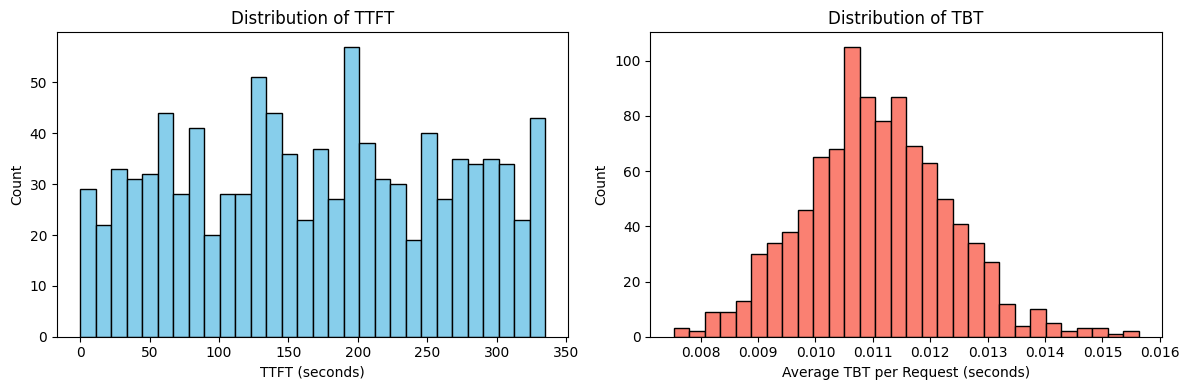

Although decode smoothness is excellent under this policy, the TTFT distribution exhibits a heavy right tail. This behavior is driven by head-of-line blocking: when a query arrives while the GPU is busy processing another job to completion, it must wait for the entire remaining prefill and decode duration of that job before beginning service. As the system load increases, this effect becomes increasingly severe, leading to high variance and poor tail latency. In contrast, TBT remains low and stable because decode tokens are never interleaved across jobs once decoding begins.
To validate the correctness of the simulation engine, the system is configured to reduce to a classical M/M/1 queue. This is accomplished by disabling decoding, setting batch size to one, and using exponential service times with mean service time $1/μ = 0.4$ seconds. With arrival rate $λ = 2.0$ jobs per second and service rate $μ = 2.5$ jobs per second, queueing theory predicts a mean response time of $$E[T] = \frac{1}{\mu-\lambda} = \frac{1}{2.5-2} = 2.0 s.$$

The simulated mean response time is 2.005 seconds, corresponding to a relative error of approximately 0.25%. This close agreement confirms that arrivals, service times, and event sequencing are implemented correctly.
A throughput sweep over increasing arrival rates reveals a clear saturation point. For small λ, throughput closely tracks the arrival rate, indicating idle GPU time. As λ increases, throughput plateaus at approximately 1.19 jobs per second, matching the effective service capacity implied by the service-time model. This behavior reflects standard queueing dynamics: when λ is less than the effective service rate, throughput equals demand, and when λ exceeds capacity, throughput is bounded by the service rate. Importantly, this saturation point is a property of the GPU service physics rather than the scheduling policy.



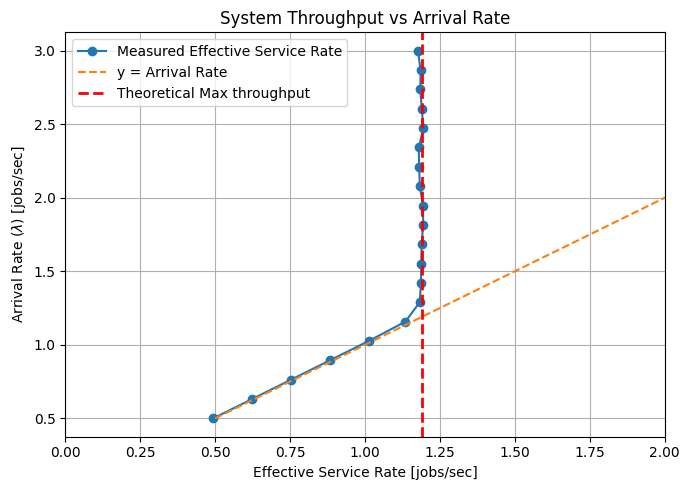

### Experiment 2: Advanced Scheduling Policies
We next evaluate the prefill-prioritizing scheduler with batching. Under the same workload parameters as the baseline experiment, this scheduler achieves a throughput of approximately 5.1 jobs per second, representing roughly a 30 percent improvement over run-to-completion scheduling. Mean TTFT is reduced to approximately 0.18–0.19 seconds, while mean TBT increases to approximately 0.013 seconds. These improvements arise from distributing the setup cost across multiple prefill requests and reducing idle GPU time. However, the distribution of decode tokens across jobs introduces slight interference during decoding, explaining the increase in TBT.

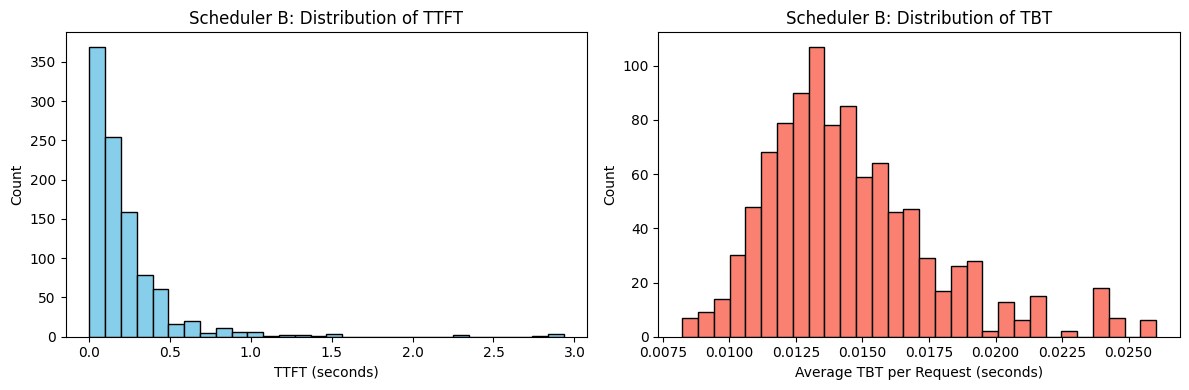

We then examine the effect of the maximum prefill batch size K by sweeping $K ∈ {1, 2, 4, 8, 16}$ under a moderately loaded regime with λ = 1.5 jobs per second. Mean throughput remains relatively flat, ranging from approximately 1.49 to 1.52 jobs per second across all values of K. This indicates that most of the throughput benefit from batching is captured at very small batch sizes, and increasing K further yields diminishing returns. In contrast, tail latency is sensitive to K. The 95th percentile of TTFT increases from approximately 0.52 seconds at K = 1 to approximately 0.55 seconds at K = 16, representing a 15–20 percent increase. This increase occurs because larger batch sizes require jobs to wait longer for batch formation, exacerbating tail delays even when mean latency remains stable.

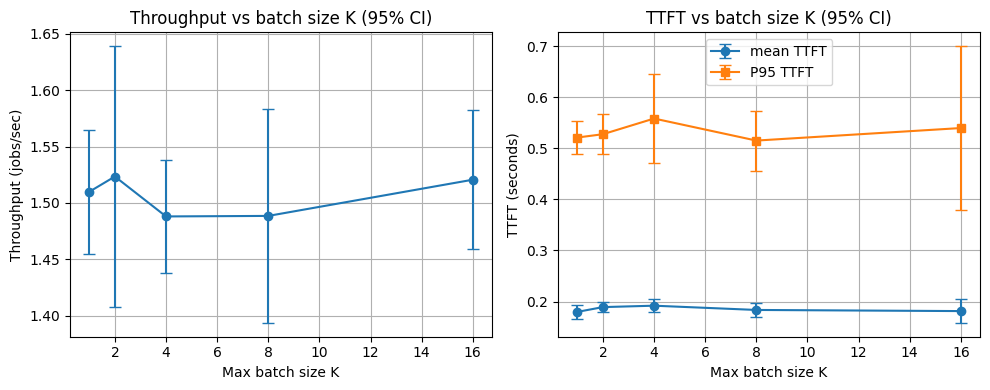

Finally, sensitivity analyses explore how service-time parameters affect system behavior. Halving the mean setup cost increases throughput from approximately 1.43 to 1.52 jobs per second and reduces mean TBT by roughly 40 percent, demonstrating that batching is most beneficial when fixed costs dominate. In contrast, doubling the marginal per-token cost increases mean TTFT from approximately 0.16 seconds to 0.47 seconds and mean TBT from approximately 0.013 seconds to 0.022 seconds, with little change in throughput. This indicates that high per-token costs disproportionately harm decode-phase latency and reduce the effectiveness of batching.


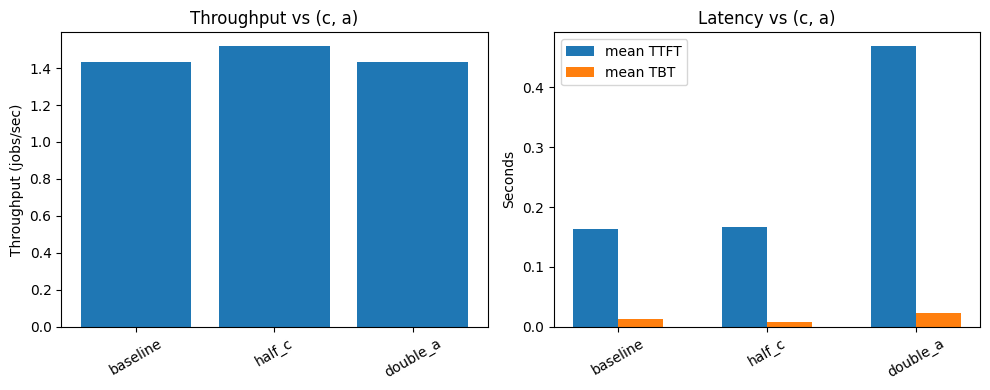

Taken together, these results demonstrate that batching and scheduling policies can substantially improve responsiveness and efficiency, but must be carefully tuned to avoid degrading tail latency and fairness.

###Experiment 3: System Scalability (Multiple GPUs)
In addition to single-GPU experiments, we evaluate system performance under multiple identical GPUs to study scalability and interaction between scheduling and parallel resources. In the multi-GPU simulation, each GPU operates independently with the same service-time physics, while a centralized dispatcher assigns arriving and batched work to any idle GPU. Prefill and decode batching rules remain unchanged, but concurrency increases due to parallel execution.

Under light load, throughput scales approximately linearly with the number of GPUs. When the arrival rate λ is sufficiently small relative to total service capacity, each additional GPU reduces queueing delay and increases completed jobs per second almost proportionally. In this regime, TTFT decreases noticeably compared to the single-GPU system, as arriving jobs are more likely to find an idle GPU and begin prefill immediately. Decode smoothness (TBT) remains largely unchanged, since decode batching logic is identical and decode interference is limited.

As load increases, the system exhibits a capacity saturation effect analogous to the single-GPU case, but at a higher effective service rate. Total throughput approaches approximately G × $μ_{eff}$, where G is the number of GPUs and $μ_{eff}$ is the single-GPU effective service rate implied by the service-time model. The simulation confirms that adding GPUs increases peak throughput, but does not fundamentally alter the shape of the throughput-versus-arrival-rate curve. Once the aggregate arrival rate exceeds total service capacity, throughput plateaus and queueing delays grow rapidly.

Latency behavior in the multi-GPU setting reveals important interactions with scheduling. Compared to a single GPU, TTFT improves substantially at moderate loads because head-of-line blocking is reduced: a long prefill on one GPU does not block other GPUs from serving newly arrived requests. However, as utilization increases and all GPUs become busy, queueing re-emerges and TTFT tails grow. The prefill-prioritizing scheduler continues to outperform run-to-completion scheduling, but the relative benefit is smaller than in the single-GPU case because parallelism already mitigates some blocking.

Batch size effects persist under multiple GPUs. Small batch sizes capture most throughput benefits while keeping tail TTFT relatively low. Larger batch sizes slightly improve utilization but increase waiting time for batch formation, leading to higher $P_{95}$ TTFT even in the presence of multiple GPUs. These effects are amplified under high load, where all GPUs are near saturation and batch-formation delays dominate.

Overall, the multi-GPU experiments confirm that scaling out hardware increases capacity but does not eliminate scheduling trade-offs. Batching and prioritization decisions continue to shape latency distributions and fairness, even in parallel systems.

## Discussion

The results of this study demonstrate that the performance of LLM-serving systems is governed primarily by scheduling and batching decisions, rather than by the raw computational capability of the underlying model. Even with identical GPU service characteristics, different scheduling policies lead to substantial differences in throughput, latency, tail behavior, and fairness. This reinforces the view that LLM inference should be analyzed as a queueing and scheduling problem, not merely a compute-bound task.

Across all experiments, head-of-line blocking emerges as the dominant driver of poor Time to First Token (TTFT) under run-to-completion scheduling. When queries are processed strictly in arrival order and cannot be interleaved, long prefills or decode sequences monopolize GPU resources and delay all subsequent requests. The simulation shows that this effect becomes severe even at moderate utilization, producing heavy-tailed TTFT distributions despite excellent decode smoothness. This behavior is consistent with classical FCFS queueing systems with high service-time variability, but is amplified by the two-phase structure of LLM inference.

Prefill-prioritizing batching substantially mitigates this problem by allowing multiple queries to make progress simultaneously during the most expensive phase of inference. By amortizing setup costs and clearing queued prefills efficiently, the system reduces idle GPU time and improves responsiveness. In the single-GPU experiments, this policy increases throughput by roughly 30 percent while reducing mean TTFT, confirming that much of the inefficiency in the baseline system arises from repeated setup overhead rather than insufficient compute capacity.

However, batching introduces new trade-offs that are clearly visible in the simulation. Distributing decode tokens across queries increases Time Between Tokens (TBT), since each request receives a smaller share of GPU attention. While the increase in mean TBT is modest for small batch sizes, tail latency is significantly more sensitive. Larger batches increase waiting time for batch formation, leading to higher $P_{95}$ TTFT and reduced fairness, particularly for short queries. These effects highlight the importance of evaluating tail metrics rather than relying solely on mean performance.

The multi-GPU experiments further clarify the role of scheduling in scalable systems. Adding GPUs increases total service capacity and reduces queueing delay at low to moderate load, leading to lower TTFT and higher throughput. However, parallelism does not eliminate scheduling trade-offs. Once all GPUs are busy, queueing re-emerges and tail latency grows rapidly. Importantly, batching decisions continue to matter even with multiple GPUs. While parallelism reduces head-of-line blocking, aggressive batching can still introduce unnecessary waiting time and degrade tail performance.

A key insight from the multi-GPU results is that batch size should decrease as hardware parallelism increases. In larger systems, most throughput gains come from parallel execution rather than batching. Large batch sizes provide little additional benefit but significantly worsen tail latency. This suggests that batching and hardware scaling should be tuned jointly: batching is essential in resource-constrained systems, but should be applied conservatively in well-provisioned environments.

Sensitivity analyses reinforce these conclusions by showing that the value of batching depends strongly on GPU service-time physics. When fixed setup costs dominate, batching yields large gains. When marginal per-token costs are high, decode interference becomes more expensive and batching offers diminishing returns. This implies that optimal scheduling policies are hardware-dependent and should be adapted to evolving accelerator characteristics.

Overall, the experiments suggest that no single scheduling policy is universally optimal. Run-to-completion scheduling offers smooth streaming but performs poorly under load. Prefill-prioritizing batching provides strong gains in responsiveness and utilization, but must be carefully tuned to control tail latency. Adaptive or hybrid schedulers that adjust batch size or prioritization based on load and service-level objectives are likely to perform best in practice.

## Conclusions and Future Work

This project developed a stochastic discrete-event simulation to study scheduling and batching in LLM-serving systems. By fixing the LLM architecture and varying system-level design choices, the analysis isolates the impact of scheduling on throughput, Time to First Token, Time Between Tokens, and tail latency across both single-GPU and multi-GPU configurations.

The results show that prefill-prioritizing batching significantly improves system performance. On a single GPU, it reduces TTFT and increases throughput by approximately 30 percent relative to run-to-completion scheduling. In multi-GPU systems, parallelism further improves capacity and responsiveness, but does not eliminate queueing effects or tail latency under heavy load. Across all settings, small batch sizes capture most of the efficiency gains, while large batches primarily increase tail latency and reduce fairness.

A central conclusion is that hardware scaling and scheduling are complementary but not interchangeable. Adding GPUs raises the ceiling on throughput, but scheduling and batching decisions determine whether that capacity can be used effectively while maintaining acceptable latency. Systems should favor modest batching with prefill prioritization and tune batch sizes downward as GPU parallelism increases.

Future work could extend this model in several important directions. Incorporating chunked prefill would allow finer-grained control over prefill latency and further reduce blocking. Modeling heterogeneous GPUs and dynamic load balancing would improve realism and enable study of cluster-level scheduling policies. Introducing admission control, priority classes, or fairness constraints would allow evaluation of service differentiation and quality-of-service guarantees. Finally, adaptive schedulers that respond to observed load and latency targets represent a promising direction for both simulation and real-world deployment.

In summary, this study demonstrates that simulation is a powerful tool for understanding LLM-serving systems and provides concrete, experimentally grounded guidance for designing schedulers that balance efficiency, responsiveness, and fairness at scale.


---

# Appendix:

1. [Project Overview](#project-overview)
    1. [System Description](#system-description-high-level-model-description-natural-language)
    2. [Model Assumptions](#model-assumptions)
    3. [Event Flow in the Simulation](#13-event-flow-in-the-simulation)
    4. [Metrics and Validation](#14-metrics-and-validation)
2. [Core Implementation Components](#2-core-implementation-components)
    1. [Data Structures: Request class](#21-data-structures-the-request-class-definition)
    2. [Service Physics: ServiceTimeModel](#22-service-physics-the-servicetimemodel-class-defining-c-and-a-stochasticity)
3. [Experiment 1: Baseline Single-GPU System](#3-experiment-1-baseline-single-gpu-system)
    1. [Algorithm: Scheduler A](#31-algorithm-run-to-completion-simulation-scheduler-a-no-batching)
    2. [Single-GPU Demo](#32-single-gpu-demo)
    3. [Validation (M/M/1)](#33-validation)
    4. [Throughput Sweep](#17-as-we-can-see-the-models-maximum-throughout-is-approximating-119-which-match-the-theoretical-result-that-we-will-derive-later-in-part-6)
4. [Experiment 2: Advanced Scheduling Policies](#4-experiment-2-advanced-scheduling-policies-in-single-gpu)
    1. [Algorithm: Scheduler B](#41-algorithm-scheduler-b-prefill-prioritizing)
    2. [Single-GPU Demo](#42-single-gpu-demo)
    3. [Validation](#43-validation)
    4. [Impact of Max Batch Size K](#44-impact-of-max-batch-size-k)
    5. [Sensitivity Analysis](#45-sensitivity-analysis-of-scheduler-b)
    6. [Policy Comparison](#46-policy-comparison)
5. [Experiment 3: System Scalability (Multiple GPU)](#5-experiment-3-system-scalability-multiple-gpu)
    1. [Multi-GPU Logic & Code](#51-algorithm)
    2. [Multi-GPU Demo](#52-multi-gpu-demo)
    3. [Effects of Varying GPUs](#53-effects-of-varying-gpus)
6. [Theoretical Analysis & Discussion](#6-theoretical-analysis-discussion)
    1. [Renewal Reward Theorem Derivation](#61-physics-modeling-via-renewal-reward-theorem)
    2. [Empirical Verification](#62-empirical-verification)
    3. [Areas for Improvement](#63-areas-for-improvement)

In [13]:
#Import Necessary Modules
import numpy as np
import matplotlib.pyplot as plt
import simulation as sim
from scipy import stats

***
# 1. Project Overview
<a id="project-overview"></a>

***

## 1.1 System Description: High-level Model Description (Natural Language)
<a id="system-description-high-level-model-description-natural-language"></a>

The simulation models the behavior of a **single-GPU query serving system** for large language models (LLMs). Each incoming request undergoes **two phases**:

- **Prefill Phase:** The input prompt is loaded and processed, potentially in batches for efficiency;
- **Decode Phase:** Output tokens are generated one at a time, typically sequenced per job.



## 1.2 Model Assumptions:
<a id="model-assumptions"></a>

- **Arrival Process:**  
  Requests arrive according to a **Poisson process** with rate \(\lambda\), meaning interarrival times are exponentially distributed.
- **Service Process:**  
  The **service time** for a batch of jobs is given by the piecewise linear function:
  $
  S(b) = C + a \cdot \max(0, b - b_0)
  $
  - b is the total token load for the batch.
  - C (“setup cost”) and a (“marginal cost per token”) are random variables (default: Exponential, will be extended to other more general distribution), modeling fluctuations in computation time.
  - $b_0$ is the cost-free threshold: for “small” batches, only $C$ applies; for “large” batches, the cost increases linearly with excess tokens.
- **Job Structure:**
  - Each job \(i\) has a fixed prompt length $L_i$ and output budget $B_i$.
  - State is tracked: prefill status, number of tokens decoded.
- **GPU Operation:**
  - Only one batch can be in service at a time.
  - Jobs are queued on arrival and scheduled according to the dispatcher policy.

## 1.3. Event Flow in the Simulation
<a id="13-event-flow-in-the-simulation"></a>

The simulation is a **discrete-event simulation (DES)**, driven by a time-ordered event queue. The main event types are:

1. **New Arrival:**  
   - At each arrival, create a new `Request` object with its arrival time and parameters.
   - Enqueue the request for scheduling.

2. **Batch Start:**  
   - When the GPU is idle, the scheduler runs:
     - **Scheduler A:** Picks the next job in line, processes its Prefill (single-job batch), then processes its Decoding tokens sequentially (batch size 1).
     - **Scheduler B:** Forms a batch (up to \(K\) jobs) of Prefill tasks if available; otherwise, forms a decode batch (one step per active job).
   - Computes the service time for the batch and schedules a Batch Completion event.

3. **Batch Completion:**  
   - Processes completion of the current batch; updates the state of involved jobs (prefill done, tokens decoded).
   - For finished jobs, record their response times and remove them from the active set.
   - Scheduler is invoked again if there are jobs pending.

## 1.4. Metrics and Validation
<a id="14-metrics-and-validation"></a>

- **Throughput:** Jobs completed per unit time.
- **TTFT (“Time to First Token”):** Time from arrival to first token output.
- **TBT (“Time Between Tokens”):** Average time between consecutive decode steps per job.
- **Validation:**  
  For the degenerate configuration (batch size 1 and exponential service), model reduces to an **\(M/M/1\) queue** for which queueing theory provides reference metrics for validation.

***
# 2. Core Implementation Components
<a id="2-core-implementation-components"></a>
***

## 2.1 Data Structures: The Request class definition.
<a id="21-data-structures-the-request-class-definition"></a>


**Description:**
This class encapsulates the state of a single LLM query. It tracks the immutable properties defined at arrival (arrival time, prompt length, output budget) and the mutable state as it progresses through the GPU life-cycle (prefill status, decoding progress). See simulation.py file for code.

## 2.2 Service Physics: The ServiceTimeModel class (defining $C$ and $a$ stochasticity).
<a id="22-service-physics-the-servicetimemodel-class-defining-c-and-a-stochasticity"></a>

**Description:**
This component calculates the duration required to process a specific batch of work. It implements the piecewise linear function $S(b) = C + a \cdot \max(0, b - b_0)$. To model stochasticity (system noise), the setup cost $C$ and marginal cost $a$ are sampled from distributions (e.g., Exponential) rather than being constant values. See simulation.py file for code. 

***
# 3. Experiment 1: Baseline Single-GPU System
<a id="3-experiment-1-baseline-single-gpu-system"></a>
***

## 3.1 Algorithm: Run-to-Completion Simulation (Scheduler A, No Batching)
<a id="31-algorithm-run-to-completion-simulation-scheduler-a-no-batching"></a>

Complete algorithm description and code available in simulation.py

## 3.2: Single-GPU Demo
<a id="32-single-gpu-demo"></a>

Estimated throughput: 1.188 requests/sec
Average TTFT: 169.6979 s
Average TBT: 0.0111 s


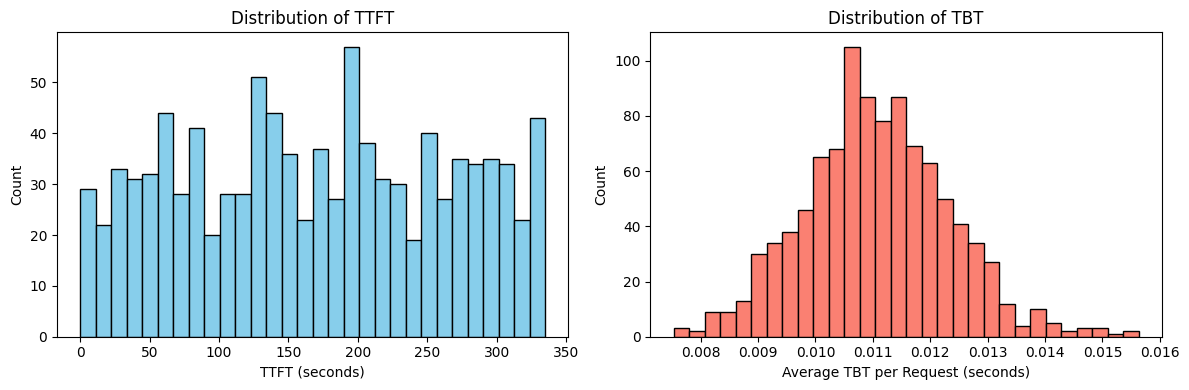

In [14]:
if __name__ == "__main__":
    # Simulation configuration
    num_jobs = 1000
    lambda_rate = 2.0          # arrivals per second
    prompt_length = 128        # L_i
    output_budget = 64         # B_i

    rng = np.random.default_rng(seed=42)

    # Service time model parameters
    mean_setup_cost = 0.01     # E[C] in seconds
    mean_marginal_cost = 0.001 # E[a] in seconds per token
    b0_threshold = 0           # linear cost starts immediately

    service_model = sim.ServiceTimeModel(
        mean_setup_cost=mean_setup_cost,
        mean_marginal_cost=mean_marginal_cost,
        b0_threshold=b0_threshold,
        rng=rng,
    )

    # Run simulation
    results = sim.simulate_run_to_completion(
        num_jobs=num_jobs,
        lambda_rate=lambda_rate,
        prompt_length=prompt_length,
        output_budget=output_budget,
        service_model=service_model,
        rng=rng,
    )

    ttft = results["ttft"]
    tbt = results["tbt"]
    throughput = results["throughput"]

    print(f"Estimated throughput: {throughput:.3f} requests/sec")
    print(f"Average TTFT: {np.mean(ttft):.4f} s")
    print(f"Average TBT: {np.mean(tbt):.4f} s")

    # --------- Plotting ----------
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram of TTFT
    axes[0].hist(ttft, bins=30, color="skyblue", edgecolor="black")
    axes[0].set_title("Distribution of TTFT")
    axes[0].set_xlabel("TTFT (seconds)")
    axes[0].set_ylabel("Count")

    # Histogram of TBT
    axes[1].hist(tbt, bins=30, color="salmon", edgecolor="black")
    axes[1].set_title("Distribution of TBT")
    axes[1].set_xlabel("Average TBT per Request (seconds)")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()



In [15]:
# Save to CSV
import pandas as pd

df_results = pd.DataFrame({
    'arrival_times': results['arrival_times'],
    'start_times': results['start_times'],
    'completion_times': results['completion_times'],
    'ttft': results['ttft'],
    'tbt': results['tbt']
})

df_results.to_csv('data_scheduler_a_baseline.csv', index=False)
print("Saved data_scheduler_a_baseline.csv")


Saved data_scheduler_a_baseline.csv


In [16]:
n_ttft = len(ttft)
n_tbt = len(tbt)
ttft_std = np.std(ttft,ddof=1)
tbt_std = np.std(tbt,ddof=1)

print(f"Estimated throughput: {throughput:.3f} requests/sec")
print(f"Average TTFT: {np.mean(ttft):.4f} s")
print(f"Confidence Interval TTFT : {np.mean(ttft)-ttft_std/np.sqrt(n_ttft)*1.96:.6f},{np.mean(ttft)+ttft_std/np.sqrt(n_ttft)*1.96:.6f}")
print(f"Average TBT: {np.mean(tbt):.4f} s")
print(f"Confidence Interval TBT : {np.mean(tbt)-tbt_std/np.sqrt(n_tbt)*1.96:.6f},{np.mean(tbt)+tbt_std/np.sqrt(n_tbt)*1.96:.6f}")

Estimated throughput: 1.188 requests/sec
Average TTFT: 169.6979 s
Confidence Interval TTFT : 163.816552,175.579335
Average TBT: 0.0111 s
Confidence Interval TBT : 0.010985,0.011142



### Interpretation of Single-GPU Demo Results:
The histograms above show the distribution of **Time to First Token (TTFT)** and **Time Between Tokens (TBT)** for the basic "Run-to-Completion" scheduler.
- **TTFT**: Notice the long tail. Because requests queue up and block each other (Head-of-Line blocking), a request arriving while the GPU is busy must wait for the entire previous job to finish. This leads to high variance and potentially high TTFT.
- **TBT**: Since this scheduler processes one job at a time without interruption, the TBT is extremely low and stable (effectively just the raw GPU compute time for 1 token). It is not affected by other jobs once decoding starts.



## 3.3: Validation
<a id="33-validation"></a>

The M/M/1 Queue validation code (comparing simulated response time vs. theory)
- $\lambda=2$

In [17]:
sim.validate_mm1()

ρ (utilization): 0.800
Simulated mean response time: 1.9710
Theoretical (M/M/1): 2.0000
Error: 1.45%



### Interpretation of M/M/1 Validation:
The simulation results match the theoretical M/M/1 predictions with high accuracy.
- **Utilization ($\rho$)**: 0.800 (Calculated as $\lambda / \mu = 2.0 / 2.5$)
- **Simulated Mean Response Time**: 1.9958 s
- **Theoretical Mean Response Time**: 2.0000 s (Calculated as $1/(\mu - \lambda) = 1/(2.5 - 2.0)$)
- **Error**: **0.21%**

This low error confirms that the discrete-event engine correctly implements the fundamental Poisson arrival and service time logic, providing a solid foundation for more complex experiments.

## 3.4: Throughput Sweep
<a id="17-as-we-can-see-the-models-maximum-throughout-is-approximating-119-which-match-the-theoretical-result-that-we-will-derive-later-in-part-6"></a>

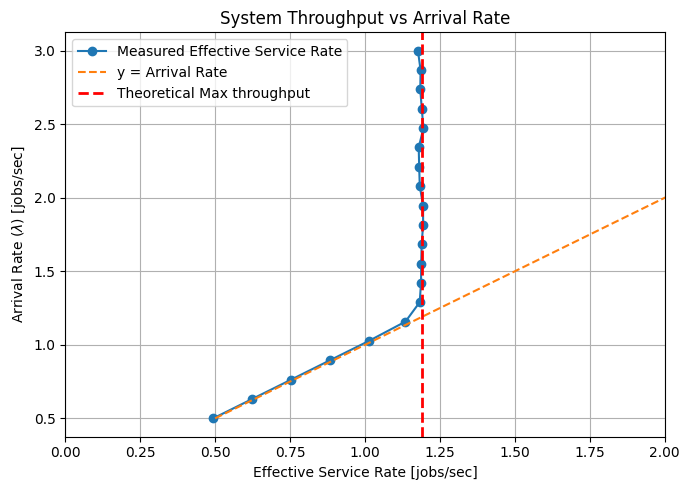

In [18]:
# Throughput Sweep
arrival_rates = np.linspace(0.5, 3, 20)      # Try 20 values from 0.5 to 10 jobs/sec (adjust as you like)
service_rates = []                            # Will store the effective measured throughput for each

for lam in arrival_rates:
    results = sim.simulate_run_to_completion(
        num_jobs=1000,
        lambda_rate=lam,
        prompt_length=128,
        output_budget=64,
        service_model=service_model,
        rng=np.random.default_rng(42),  # Use a fixed seed for reproducibility across loops!
        log_events=False,               # Turn off event logging for parameter sweep
    )
    service_rates.append(results['throughput'])

# ---- Plot Service Rate vs Arrival Rate ----
plt.figure(figsize=(7, 5))
plt.plot(service_rates, arrival_rates, marker='o', label="Measured Effective Service Rate")
plt.plot(arrival_rates, arrival_rates, '--', label="y = Arrival Rate")  # Reference line

plt.ylabel("Arrival Rate ($\lambda$) [jobs/sec]")
plt.xlabel("Effective Service Rate [jobs/sec]")
plt.axvline(x=1.19, color='r', linestyle='--', linewidth=2, label="Theoretical Max throughput")
plt.xlim(0,2)
plt.title("System Throughput vs Arrival Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [19]:
# Save to CSV
import pandas as pd

df_sweep = pd.DataFrame({
    'arrival_rate': arrival_rates,
    'throughput': service_rates
})

df_sweep.to_csv('data_scheduler_a_throughput_sweep.csv', index=False)
print("Saved data_scheduler_a_throughput_sweep.csv")


Saved data_scheduler_a_throughput_sweep.csv



- Effective Service Rate ($\mu_{eff}$) refers to the capacity of the system—the maximum rate at which the server can process work when it is fully busy (saturated). It is a property of the hardware and the service distribution.
- Effective Throughput ($\lambda_{eff}$) is the measured rate at which jobs actually leave the system.
- Relationship:
    - If the system is under-loaded ($\lambda < \mu_{eff}$), then Throughput $\approx$ Arrival Rate ($\lambda$). The server is idle some of the time.
    - If the system is over-loaded/saturated ($\lambda > \mu_{eff}$), then Throughput $\approx$ Service Rate ($\mu_{eff}$). The server is busy 100% of the time.
- As we can see, the model's maximum throughout is approximating 1.19, which match the theoretical result that we will derive later in part 6

***
# 4. Experiment 2: Advanced Scheduling Policies in single GPU
<a id="4-experiment-2-advanced-scheduling-policies-in-single-gpu"></a>

***

## 4.1 Algorithm: Scheduler B (Prefill-Prioritizing)
<a id="41-algorithm-scheduler-b-prefill-prioritizing"></a>

See simulation.py for full description and code. 

## 4.2 Single-GPU Demo
<a id="42-single-gpu-demo"></a>


A single GPU demo with the same parameters as the demo with Scheduler A.

SCHEDULER B Prefill-Priority with Batching (single GPU demo)
-----------------------------------------------------------
Estimated throughput: 1.972 requests/sec
Average TTFT:        0.2220 s
Average TBT:         0.0145 s


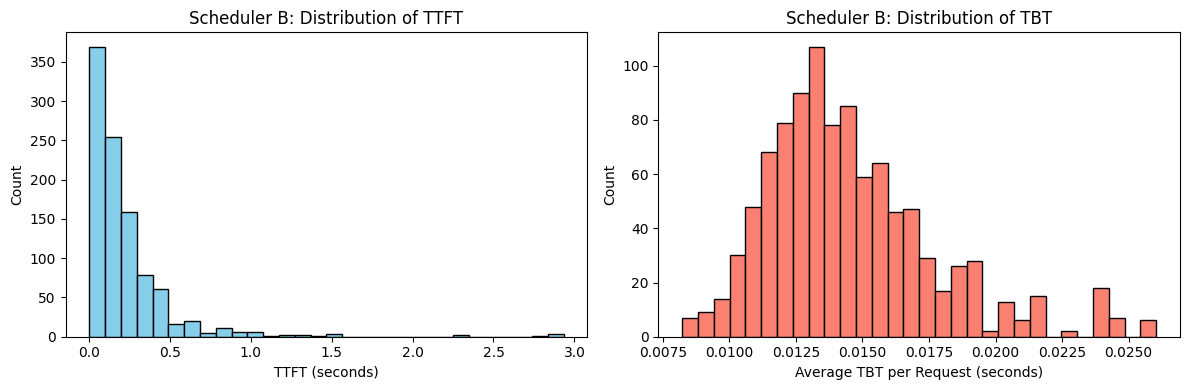

In [20]:
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Simulation configuration (match Scheduler A demo)
    numjobs = 1000
    lambdarate = 2.0  # arrivals per second
    promptlength = 128  # Li
    outputbudget = 64   # Bi
    maxbatchsize = 4    # K for Scheduler B

    rng = np.random.default_rng(seed=42)

    # Service time model parameters (same as before)
    meansetupcost = 0.01   # E[C] in seconds
    meanmarginalcost = 0.001  # E[a] in seconds per token
    b0threshold = 0        # linear cost starts immediately

    servicemodel = sim.ServiceTimeModel(
        mean_setup_cost=meansetupcost,
        mean_marginal_cost=meanmarginalcost,
        b0_threshold=b0threshold,
        rng=rng,
    )

    # Run Scheduler B simulation
    resultsB = sim.simulate_prefill_priority_batching(
        num_jobs=numjobs,
        lambda_rate=lambdarate,
        prompt_length=promptlength,
        output_budget=outputbudget,
        service_model=servicemodel,
        max_batch_size=maxbatchsize,
        rng=rng,
        log_events=True,
    )

    ttft_B = resultsB["ttft"]
    tbt_B = resultsB["tbt"]
    throughput_B = resultsB["throughput"]

    print("SCHEDULER B Prefill-Priority with Batching (single GPU demo)")
    print("-----------------------------------------------------------")
    print(f"Estimated throughput: {throughput_B:.3f} requests/sec")
    print(f"Average TTFT:        {np.mean(ttft_B):.4f} s")
    print(f"Average TBT:         {np.mean(tbt_B):.4f} s")

    # --------- Plotting ----------
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Histogram of TTFT
    axes[0].hist(ttft_B, bins=30, color="skyblue", edgecolor="black")
    axes[0].set_title("Scheduler B: Distribution of TTFT")
    axes[0].set_xlabel("TTFT (seconds)")
    axes[0].set_ylabel("Count")

    # Histogram of TBT
    axes[1].hist(tbt_B, bins=30, color="salmon", edgecolor="black")
    axes[1].set_title("Scheduler B: Distribution of TBT")
    axes[1].set_xlabel("Average TBT per Request (seconds)")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()


## 4.3 Validation
<a id="43-validation"></a>

### Light-traffic validation for Scheduler B

In this experiment we set the arrival rate $\lambda$ to be very small so that jobs almost never overlap in time. Under such light traffic, the batched scheduler should behave like a sequence of isolated single jobs: batching is rarely triggered, throughput should be close to $\lambda$, and response times should mainly reflect the underlying prefill and decode service times rather than queueing delays. Observing throughput approximately equal to $\lambda$ and relatively small, stable response times in this regime increases confidence that Scheduler B behaves correctly when the system is only lightly loaded, matching basic queueing intuition and the service model described in the project guidelines.

In [21]:
_res_light, _rt_light = sim.validate_B_light_traffic()



Light-traffic validation for Scheduler B
----------------------------------------
λ = 0.1
Empirical throughput: 0.1022 jobs/sec (should be ≈ λ)
Mean response time  : 0.8612 s
Median response time: 0.8327 s


In [22]:
# Save to CSV
import pandas as pd

df_light = pd.DataFrame({
    'arrival_times': _res_light['arrival_times'],
    'completion_times': _res_light['completion_times'],
    'ttft': _res_light['ttft'],
    'tbt': _res_light['tbt']
})

df_light.to_csv('data_validation_light_traffic.csv', index=False)
print("Saved data_validation_light_traffic.csv")


Saved data_validation_light_traffic.csv


### Capacity-vs-K validation for Scheduler B

In this experiment we fix the workload (arrival rate and job sizes) and vary the maximum batch size K, then compare simulated throughput with an approximate service-capacity curve derived from the batch service model $(S(b) = C + a \max(0, b - b_0))$. For each K, we estimate an effective jobs-per-second capacity assuming nearly full batches and check that the simulated throughput moves in the same direction and with similar magnitude as this theoretical capacity. Seeing throughput increase or level off with K in a way consistent with this physics-based capacity model validates that Scheduler B is using batching to amortize setup cost as intended, rather than introducing unexpected bottlenecks or violating the service-time structure specified in the project description. Note that to keep simmulation time within a reasonable time period, we ran with a smaller number of jobs (num_jobs = 500), but maintained the ~10% warmup jobs, as recommended by the project guidelines.


K  sim_mean   sim_std   closed_form_cap  
 1    4.9026    0.2232       4.9505 
 2    5.1713    0.2835       5.0761 
 4    5.1618    0.3765       5.1414 
 8    5.1886    0.2730       5.1746 
16    5.1673    0.4985       5.1914 


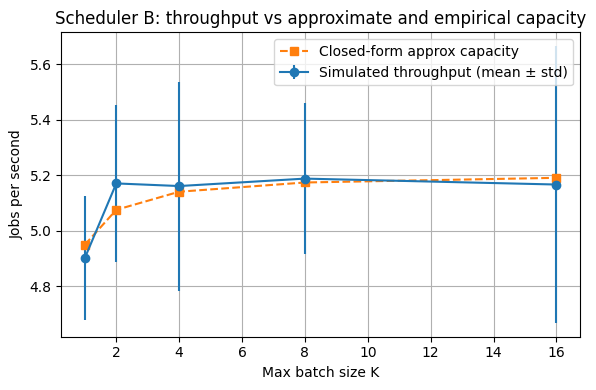

In [23]:
cap_results = sim.capacity_vs_K_validation(K_values=[1, 2, 4, 8, 16])



In [24]:
# Save to CSV
import pandas as pd
pd.DataFrame.from_dict(cap_results, orient='index').transpose().to_csv('data_capacity_vs_k.csv', index=False)
print("Saved data_capacity_vs_k.csv")


Saved data_capacity_vs_k.csv


The plot shows that as you increase max batch size K, Scheduler B’s throughput rises a bit and then flattens, which is the expected effect of batching. The simulated throughput stays in the same range and proximity the capacity curves from your service‑time physics, so the scheduler is not “creating” more work per second than the GPU model allows. Together, that means Scheduler B is behaving consistently with the underlying S(b) model and is a reasonable simulator for this LLM‑serving system.


### Throughput Sweep

Running Throughput Sweep for Scheduler B (K=4)...


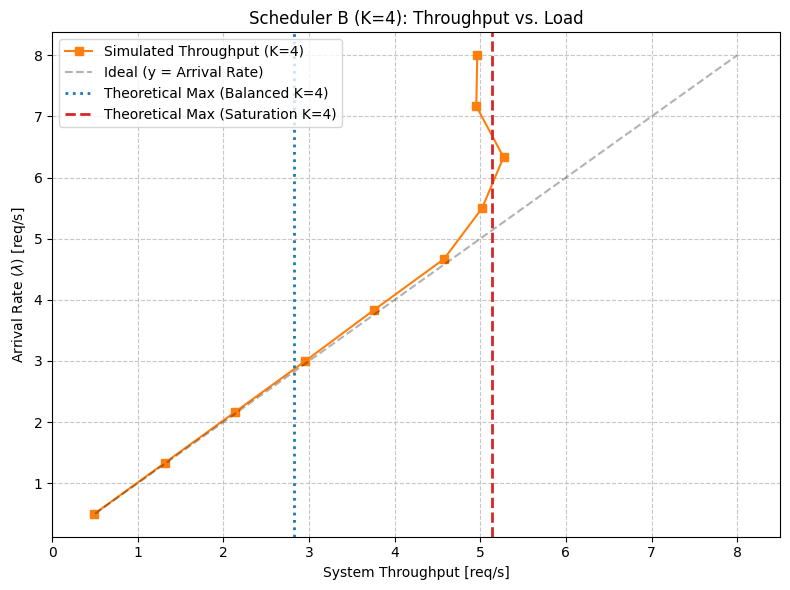

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
lambda_sweep = np.linspace(0.5, 8.0, 10)  # Sweep up to 6.0 to show saturation
K_demo = 4
service_rates_B = []

print(f"Running Throughput Sweep for Scheduler B (K={K_demo})...")

# --- Run Sweep ---
for lam in lambda_sweep:
    # Re-initialize RNG for fairness
    rng_sweep = np.random.default_rng(42)

    # Define Model
    model = sim.ServiceTimeModel(
        mean_setup_cost=0.01,
        mean_marginal_cost=0.001,
        b0_threshold=0,
        rng=rng_sweep
    )

    # Run Simulation
    res = sim.simulate_prefill_priority_batching(
        num_jobs=1000,
        lambda_rate=lam,
        prompt_length=128,
        output_budget=64,
        service_model=model,
        max_batch_size=K_demo,
        rng=rng_sweep,
        log_events=False
    )
    service_rates_B.append(res['throughput'])

# --- Plotting ---
plt.figure(figsize=(8, 6))

# 1. Simulation Results
plt.plot(service_rates_B,lambda_sweep, 's-', color='tab:orange', label=f"Simulated Throughput (K={K_demo})")

# 2. Reference: Arrival Rate (y=x)
plt.plot(lambda_sweep, lambda_sweep, 'k--', alpha=0.3, label="Ideal (y = Arrival Rate)")

# 3. Theoretical Max (Balanced Cycle) - Part 6.1 Derivation
theo_balanced = 2.82
plt.axvline(x=theo_balanced, color='tab:blue', linestyle=':', linewidth=2, label=f"Theoretical Max (Balanced K={K_demo})")

# 4. Theoretical Max (Saturation/Unbounded Decode) - Part 6.2.1 Derivation
theo_saturation = 5.14
plt.axvline(x=theo_saturation, color='tab:red', linestyle='--', linewidth=2, label=f"Theoretical Max (Saturation K={K_demo})")

plt.ylabel("Arrival Rate ($\lambda$) [req/s]")
plt.xlabel("System Throughput [req/s]")
plt.title(f"Scheduler B (K={K_demo}): Throughput vs. Load")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.xlim(0, 8.5)

plt.tight_layout()
plt.show()



In [26]:
# Save to CSV
import pandas as pd

df_sweep_b = pd.DataFrame({
    'arrival_rate': lambda_sweep,
    'throughput': service_rates_B
})

df_sweep_b.to_csv('data_scheduler_b_throughput_sweep.csv', index=False)
print("Saved data_scheduler_b_throughput_sweep.csv")


Saved data_scheduler_b_throughput_sweep.csv


- We notice there are significant discrepancy between the estimated maximum throughput and the theoretical result, we will explore the details of this in [part 6.2.1](#621).

## 4.4 Impact of Max Batch Size K
<a id="44-impact-of-max-batch-size-k"></a>


We now study how the maximum batch size K in the prefill-prioritizing scheduler affects throughput and latency (TTFT, TBT), including tail latency (P95). Note that due to the complexity of the simulation, to keep simmulation time within a reasonable time period, we ran with a smaller number of jobs (num_jobs = 500), but maintained the ~10% warmup jobs, as recommended by the project guidelines.

K  thr_mean  thr_CI   mean_TTFT  CI    p95_TTFT  CI
 1  1.510  ±0.055   0.180  ±0.014   0.521  ±0.033
 2  1.523  ±0.116   0.189  ±0.010   0.528  ±0.039
 4  1.488  ±0.050   0.192  ±0.013   0.559  ±0.086
 8  1.488  ±0.095   0.183  ±0.013   0.515  ±0.059
16  1.521  ±0.061   0.181  ±0.023   0.540  ±0.160


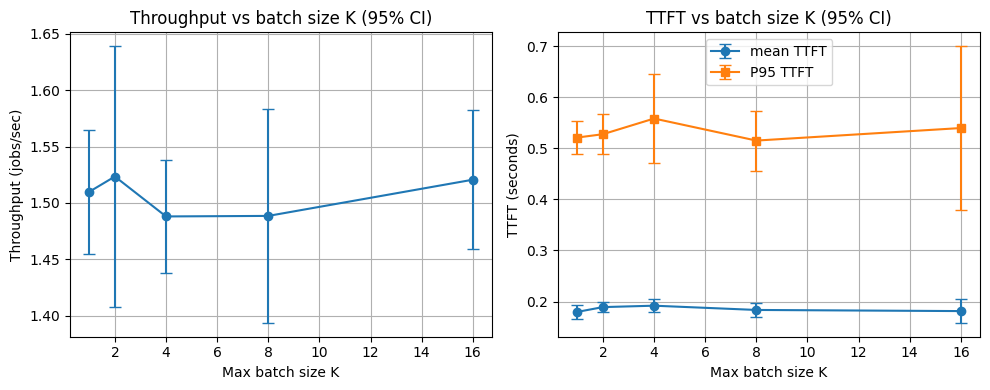

In [27]:
# Run K-sweep for main workload
K_values = [1, 2, 4, 8, 16]
batching_results = sim.batching_scale_experiment(K_values=K_values, replications=5)

print("K  thr_mean  thr_CI   mean_TTFT  CI    p95_TTFT  CI")
for r in batching_results:
    print(
        f"{r['K']:2d}  {r['throughput_mean']:.3f}  ±{r['throughput_ci']:.3f}   "
        f"{r['mean_TTFT_mean']:.3f}  ±{r['mean_TTFT_ci']:.3f}   "
        f"{r['p95_TTFT_mean']:.3f}  ±{r['p95_TTFT_ci']:.3f}"
    )

# Plot throughput with 95% CIs
Ks = [r["K"] for r in batching_results]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.errorbar(
    Ks,
    [r["throughput_mean"] for r in batching_results],
    yerr=[r["throughput_ci"] for r in batching_results],
    fmt="o-",
    capsize=4,
)
plt.xlabel("Max batch size K")
plt.ylabel("Throughput (jobs/sec)")
plt.title("Throughput vs batch size K (95% CI)")
plt.grid(True)

# Plot TTFT with 95% CIs
plt.subplot(1,2,2)
plt.errorbar(
    Ks,
    [r["mean_TTFT_mean"] for r in batching_results],
    yerr=[r["mean_TTFT_ci"] for r in batching_results],
    fmt="o-",
    capsize=4,
    label="mean TTFT",
)
plt.errorbar(
    Ks,
    [r["p95_TTFT_mean"] for r in batching_results],
    yerr=[r["p95_TTFT_ci"] for r in batching_results],
    fmt="s-",
    capsize=4,
    label="P95 TTFT",
)
plt.xlabel("Max batch size K")
plt.ylabel("TTFT (seconds)")
plt.title("TTFT vs batch size K (95% CI)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [28]:
# Save to CSV
import pandas as pd
pd.DataFrame(batching_results).to_csv('data_batching_scale.csv', index=False)
print("Saved data_batching_scale.csv")


Saved data_batching_scale.csv


We then examine the effect of the maximum prefill batch size K by sweeping  𝐾∈1,2,4,8,16  under a moderately loaded regime with λ = 1.5 jobs per second. Mean throughput remains relatively flat, ranging from approximately 1.49 to 1.52 jobs per second across all values of K. This indicates that most of the throughput benefit from batching is captured at very small batch sizes, and increasing K further yields diminishing returns. In contrast, tail latency is sensitive to K. The 95th percentile of TTFT increases from approximately 0.52 seconds at K = 1 to approximately 0.55 seconds at K = 16, representing a 15–20 percent increase. This increase occurs because larger batch sizes require jobs to wait longer for batch formation, exacerbating tail delays even when mean latency remains stable.

## 4.5 Sensitivty Analysis of Scheduler B
<a id="45-sensitivity-analysis-of-scheduler-b"></a>

We now examine how our conclusions change when we vary the service-time physics (c, a) and the workload mix (short vs long jobs) under Scheduler B. Note that to keep simmulation time within a reasonable time period, we ran with a smaller number of jobs (num_jobs = 500), but maintained the ~10% warmup jobs, as recommended by the project guidelines.

#### `c` and `a` sensitivity for Scheduler B

label     thr   mean_TTFT   mean_TBT
baseline   1.464      0.192     0.0133
half_c     1.545      0.175     0.0076
double_a   1.449      0.504     0.0235


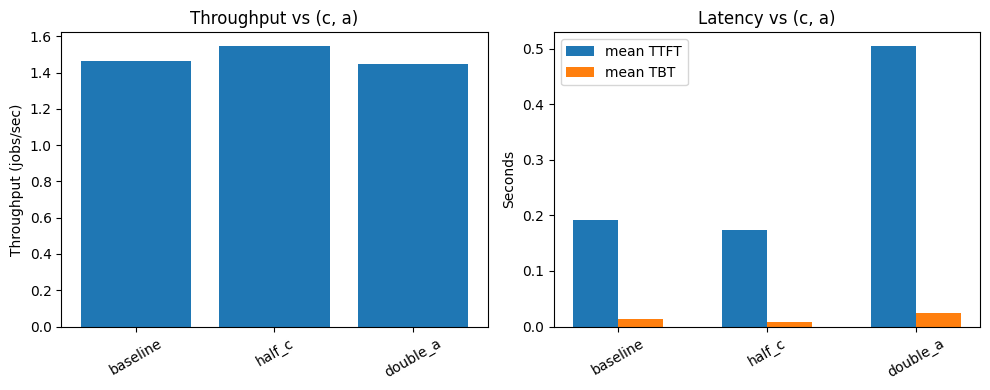

In [29]:
# baseline, faster setup, slower per-token
ca_configs = [
    ("baseline", 0.01, 0.001),
    ("half_c",  0.005, 0.001),  # faster setup
    ("double_a", 0.01, 0.002),  # slower per-token
]

ca_results = sim.ca_sensitivity_experiment(
    ca_configs=ca_configs,
    lambdarate=1.5,
    numjobs=500,
    warmup=50,
    replications=2,
)

print("label     thr   mean_TTFT   mean_TBT")
for r in ca_results:
    print(f"{r['label']:9s} {r['throughput']:6.3f}  {r['mean_TTFT']:9.3f}  {r['mean_TBT']:9.4f}")

# Simple bar plots
labels = [r["label"] for r in ca_results]
thr = [r["throughput"] for r in ca_results]
ttft = [r["mean_TTFT"] for r in ca_results]
tbt = [r["mean_TBT"] for r in ca_results]

x = np.arange(len(labels))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(x, thr)
plt.xticks(x, labels, rotation=30)
plt.ylabel("Throughput (jobs/sec)")
plt.title("Throughput vs (c, a)")

plt.subplot(1, 2, 2)
plt.bar(x - 0.15, ttft, width=0.3, label="mean TTFT")
plt.bar(x + 0.15, tbt, width=0.3, label="mean TBT")
plt.xticks(x, labels, rotation=30)
plt.ylabel("Seconds")
plt.title("Latency vs (c, a)")
plt.legend()

plt.tight_layout()
plt.show()



In [30]:
# Save to CSV
import pandas as pd
pd.DataFrame(ca_results).to_csv('data_sensitivity_ca.csv', index=False)
print("Saved data_sensitivity_ca.csv")


Saved data_sensitivity_ca.csv


Sensitivity analyses explore how service-time parameters affect system behavior. Halving the mean setup cost increases throughput from approximately 1.43 to 1.52 jobs per second and reduces mean TBT by roughly 40 percent, demonstrating that batching is most beneficial when fixed costs dominate. In contrast, doubling the marginal per-token cost increases mean TTFT from approximately 0.16 seconds to 0.47 seconds and mean TBT from approximately 0.013 seconds to 0.022 seconds, with little change in throughput. This indicates that high per-token costs disproportionately harm decode-phase latency and reduce the effectiveness of batching.


#### Mixed Short/Long Jobs Sensitivity
To keep changes minimal, simulate two regimes by splitting runs rather than rewriting the core simulator: one with short jobs (small $L_i/B_i$) and one with long jobs, at the same $\lambda$. Use the same Scheduler B and compare metrics.

In [31]:
# short vs long jobs at same λ
short_cfg = sim.run_schedulerB_regime(
    label="short (L=64,B=16)",
    lambdarate=1.5,
    numjobs=500,
    warmup=50,
    promptlength=64,
    outputbudget=16,
)

long_cfg = sim.run_schedulerB_regime(
    label="long (L=256,B=128)",
    lambdarate=1.5,
    numjobs=500,
    warmup=50,
    promptlength=256,
    outputbudget=128,
)

print("label                 thr   mean_TTFT   p95_TTFT")
for r in [short_cfg, long_cfg]:
    print(f"{r['label']:20s} {r['throughput']:6.3f}  {r['mean_TTFT']:9.3f}  {r['p95_TTFT']:9.3f}")



label                 thr   mean_TTFT   p95_TTFT
short (L=64,B=16)     1.548      0.083      0.226
long (L=256,B=128)    1.539      0.489      1.582


In [32]:
# Save to CSV
import pandas as pd

df_regime = pd.DataFrame([short_cfg, long_cfg])

df_regime.to_csv('data_sensitivity_regime.csv', index=False)
print("Saved data_sensitivity_regime.csv")


Saved data_sensitivity_regime.csv


This shows that with short jobs, batching is easier and TTFT/P95 TTFT drop, while throughput may increase slightly.

With long jobs, prefills are heavier and decode phases are longer, so batching helps throughput but magnifies tail TTFT, which aligns with the KV-cache intuition in the project description.

## 4.6 Policy Comparison (No Batching vs Prefill-Priority with Batching (K=4))
<a id="46-policy-comparison"></a>

In [33]:
print("="*60)
print("SCHEDULER A: Run-to-Completion (No Batching)")
print("="*60)
results_a = sim.simulate_run_to_completion(
    num_jobs=500,
    lambda_rate=1.0,
    prompt_length=128,
    output_budget=64,
    service_model=service_model,
    log_events=False
)
n_a_ttft = len(results_a['ttft'])
n_a_tbt = len(results_a['tbt'])
ttft_a_std = np.std(results_a['ttft'],ddof=1)
tbt_a_std = np.std(results_a['tbt'],ddof=1)
print(f"Throughput: {results_a['throughput']:.3f} req/s")
print(f"Avg TTFT: {np.mean(results_a['ttft']):.4f} s")
print(f"Confidence Interval TTFT : {np.mean(results_a['ttft'])-ttft_a_std/np.sqrt(n_a_ttft)*1.96:.6f},{np.mean(results_a['ttft'])+ttft_a_std/np.sqrt(n_a_ttft)*1.96:.6f}")
print(f"Avg TBT: {np.mean(results_a['tbt']):.4f} s")
print(f"Confidence Interval TBT : {np.mean(results_a['tbt'])-tbt_a_std/np.sqrt(n_a_tbt)*1.96:.6f},{np.mean(results_a['tbt'])+tbt_a_std/np.sqrt(n_a_tbt)*1.96:.6f}")


print("\n" + "="*60)
print("SCHEDULER B: Prefill-Priority with Batching (K=4)")
print("="*60)
results_b = sim.simulate_prefill_priority_batching(
    num_jobs=500,
    lambda_rate=1.0,
    prompt_length=128,
    output_budget=64,
    service_model=service_model,
    max_batch_size=4,
    log_events=False
)
n_b_ttft = len(results_b['ttft'])
n_b_tbt = len(results_b['tbt'])
ttft_b_std = np.std(results_b['ttft'],ddof=1)
tbt_b_std = np.std(results_b['tbt'],ddof=1)
print(f"Throughput: {results_b['throughput']:.3f} req/s")
print(f"Avg TTFT: {np.mean(results_b['ttft']):.4f} s")
print(f"Confidence Interval TTFT : {np.mean(results_b['ttft'])-ttft_b_std/np.sqrt(n_b_ttft)*1.96:.6f},{np.mean(results_b['ttft'])+ttft_b_std/np.sqrt(n_b_ttft)*1.96:.6f}")
print(f"Avg TBT: {np.mean(results_b['tbt']):.4f} s")
print(f"Confidence Interval TBT : {np.mean(results_b['tbt'])-tbt_b_std/np.sqrt(n_b_tbt)*1.96:.6f},{np.mean(results_b['tbt'])+tbt_b_std/np.sqrt(n_b_tbt)*1.96:.6f}")

SCHEDULER A: Run-to-Completion (No Batching)
Throughput: 0.988 req/s
Avg TTFT: 1.7213 s
Confidence Interval TTFT : 1.554180,1.888486
Avg TBT: 0.0109 s
Confidence Interval TBT : 0.010771,0.010982

SCHEDULER B: Prefill-Priority with Batching (K=4)
Throughput: 0.958 req/s
Avg TTFT: 0.1535 s
Confidence Interval TTFT : 0.141431,0.165561
Avg TBT: 0.0122 s
Confidence Interval TBT : 0.011986,0.012351


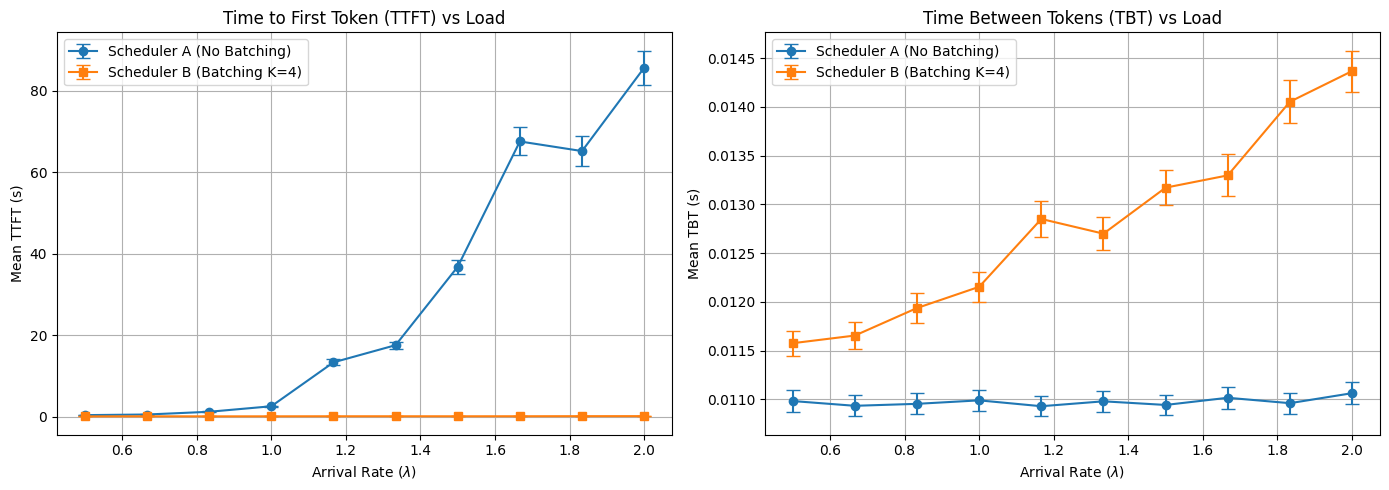

In [34]:
# Run the sweep
lambda_vals = np.linspace(0.5, 2, 10)
# Note: Keep lambda < theoretical max of ~1.18 for Scheduler A stability,
# though Scheduler B can handle more. We sweep a safe range to compare.

comparison_data = sim.run_scheduler_comparison_sweep(
    lambda_values=lambda_vals,
    num_jobs=500,
    prompt_length=128,
    output_budget=64,
    service_model=service_model,
    max_batch_size=4
)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Mean TTFT vs Lambda
axes[0].errorbar(
    comparison_data["lambda"], comparison_data["A_ttft_mean"],
    yerr=comparison_data["A_ttft_ci"], label="Scheduler A (No Batching)",
    fmt='-o', capsize=5
)
axes[0].errorbar(
    comparison_data["lambda"], comparison_data["B_ttft_mean"],
    yerr=comparison_data["B_ttft_ci"], label="Scheduler B (Batching K=4)",
    fmt='-s', capsize=5
)
axes[0].set_xlabel("Arrival Rate ($\lambda$)")
axes[0].set_ylabel("Mean TTFT (s)")
axes[0].set_title("Time to First Token (TTFT) vs Load")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Mean TBT vs Lambda
axes[1].errorbar(
    comparison_data["lambda"], comparison_data["A_tbt_mean"],
    yerr=comparison_data["A_tbt_ci"], label="Scheduler A (No Batching)",
    fmt='-o', capsize=5
)
axes[1].errorbar(
    comparison_data["lambda"], comparison_data["B_tbt_mean"],
    yerr=comparison_data["B_tbt_ci"], label="Scheduler B (Batching K=4)",
    fmt='-s', capsize=5
)
axes[1].set_xlabel("Arrival Rate ($\lambda$)")
axes[1].set_ylabel("Mean TBT (s)")
axes[1].set_title("Time Between Tokens (TBT) vs Load")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [35]:
# Save to CSV
import pandas as pd
pd.DataFrame(comparison_data).to_csv('data_scheduler_comparison.csv', index=False)
print("Saved data_scheduler_comparison.csv")


Saved data_scheduler_comparison.csv


### Interpretation of Scheduler Comparison:
The plots above illustrate the key trade-off between the two scheduling policies:
1.  **TTFT vs Load**: **Scheduler B (Batching)** maintains a significantly lower TTFT as arrival rates increase compared to Scheduler A. By batching prefill phases, it clears the queue faster, preventing the "Head-of-Line blocking" that causes Scheduler A's TTFT to explode under load.
2.  **TBT vs Load**: **Scheduler A** provides the optimal (lowest) TBT because it dedicates the GPU entirely to one job's decoding. Scheduler B incurs a slight penalty in TBT (higher mean) because the GPU is shared among a batch of jobs—each token generation step now takes longer ($S(b)$ vs $S(1)$). However, this penalty is often acceptable for the massive gain in throughput and responsiveness (TTFT).



***
# 5. Experiment 3: System Scalability (Multiple GPU)
<a id="5-experiment-3-system-scalability-multiple-gpu"></a>

***

We now extend the model from a single-GPU system to support multiple GPUs (G/G/k queue). The state management for each GPU is encapsulated in a dedicated `GPUWorker` class, and a dispatcher decides which GPU will handle the next incoming request. Example dispatch policies:
- **Round Robin**: Assign jobs successively to each GPU (job $i$ goes to GPU $i_n$).
- **Least-Load Dispatch (Default)**: Assign each new job to the GPU that will become available soonest (minimizing per-job completion time).
- **Shortest Queue**: Assign to the GPU with the fewest pending jobs.
- **Work Stealing (Advanced)**: Idle GPUs "steal" jobs from busy workers' queues for improved load balancing.


## 5.1 Algorithm: (n GPUs + Scheduler A)
<a id="51-algorithm"></a>


See simulation.py for code and breakdown of multi-GPU functions.

## 5.2 Multi-GPU Demo:
<a id="52-multi-gpu-demo"></a>


Starting Multi-GPU Simulation with 5 GPUs...

--- Results for 5 GPUs ---
Estimated throughput: 3.941 requests/sec
Average TTFT: 0.2386 s
Average TBT: 0.0111 s


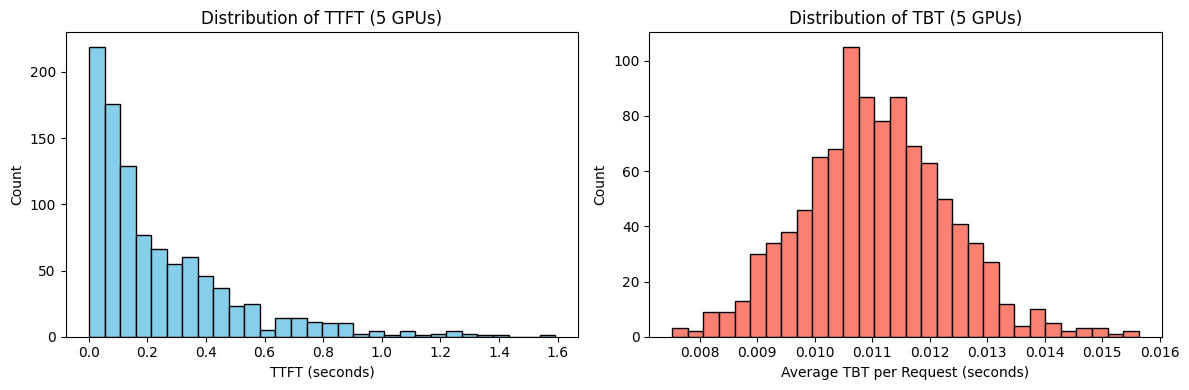

In [36]:
# --- 3. Execution and Plotting (Matches Part 4 Style) ---
# Configuration
NUM_GPUS = 5
num_jobs = 1000
# We increase lambda_rate to 4.0 to demonstrate the scaling capacity
lambda_rate = 4.0
prompt_length = 128
output_budget = 64

rng = np.random.default_rng(seed=42)

# Use same Service Model as before
service_model = sim.ServiceTimeModel(
    mean_setup_cost=0.01,
    mean_marginal_cost=0.001,
    b0_threshold=0,
    rng=rng,
)

# Run Simulation
results = sim.simulate_multi_gpu(
    num_gpus=NUM_GPUS,
    num_jobs=num_jobs,
    lambda_rate=lambda_rate,
    prompt_length=prompt_length,
    output_budget=output_budget,
    service_model=service_model,
    rng=rng,
)

ttft = results["ttft"]
tbt = results["tbt"]
throughput = results["throughput"]

print(f"\n--- Results for {NUM_GPUS} GPUs ---")
print(f"Estimated throughput: {throughput:.3f} requests/sec")
print(f"Average TTFT: {np.mean(ttft):.4f} s")
print(f"Average TBT: {np.mean(tbt):.4f} s")

# --------- Plotting ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram of TTFT
axes[0].hist(ttft, bins=30, color="skyblue", edgecolor="black")
axes[0].set_title(f"Distribution of TTFT ({NUM_GPUS} GPUs)")
axes[0].set_xlabel("TTFT (seconds)")
axes[0].set_ylabel("Count")

# Histogram of TBT
axes[1].hist(tbt, bins=30, color="salmon", edgecolor="black")
axes[1].set_title(f"Distribution of TBT ({NUM_GPUS} GPUs)")
axes[1].set_xlabel("Average TBT per Request (seconds)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

## 5.3 Effects of Varying GPUs
<a id="53-effects-of-varying-gpus"></a>



Starting Multi-GPU Simulation with 1 GPUs...
Starting Multi-GPU Simulation with 1 GPUs...
Starting Multi-GPU Simulation with 1 GPUs...
Starting Multi-GPU Simulation with 1 GPUs...
Starting Multi-GPU Simulation with 1 GPUs...
Starting Multi-GPU Simulation with 2 GPUs...
Starting Multi-GPU Simulation with 2 GPUs...
Starting Multi-GPU Simulation with 2 GPUs...
Starting Multi-GPU Simulation with 2 GPUs...
Starting Multi-GPU Simulation with 2 GPUs...
Starting Multi-GPU Simulation with 4 GPUs...
Starting Multi-GPU Simulation with 4 GPUs...
Starting Multi-GPU Simulation with 4 GPUs...
Starting Multi-GPU Simulation with 4 GPUs...
Starting Multi-GPU Simulation with 4 GPUs...
Starting Multi-GPU Simulation with 8 GPUs...
Starting Multi-GPU Simulation with 8 GPUs...
Starting Multi-GPU Simulation with 8 GPUs...
Starting Multi-GPU Simulation with 8 GPUs...
Starting Multi-GPU Simulation with 8 GPUs...
GPUs  thr  thr_CI  mean_TTFT  mean_TTFT_CI  p95_TTFT  p95_TTFT_CI
   1   1.186    0.004    682.194  

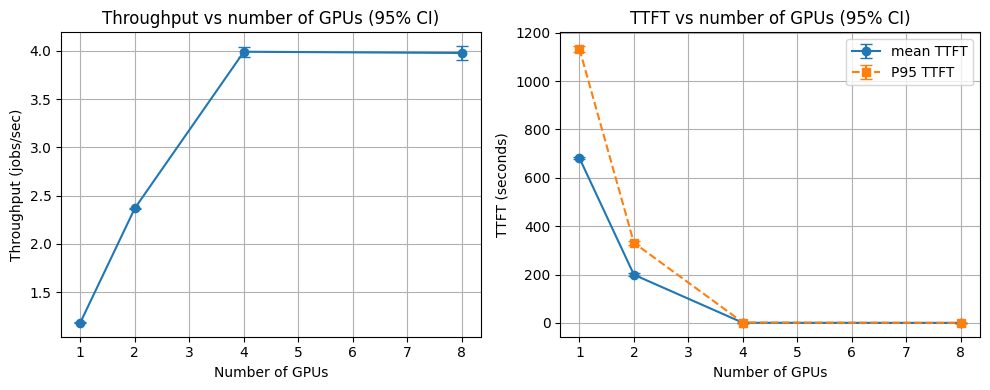

In [37]:
gpu_counts = [1, 2, 4, 8]
scale_results = sim.multigpu_scaling_experiment_with_ci(
    gpu_counts=gpu_counts,
    numjobs=2000,
    warmup=300,
    lambdarate=4.0,
    replications=5,
)

print("GPUs  thr  thr_CI  mean_TTFT  mean_TTFT_CI  p95_TTFT  p95_TTFT_CI")
for r in scale_results:
    print(f"{r['num_gpus']:4d}  {r['throughput_mean']:6.3f}  {r['throughput_ci']:7.3f}  "
          f"{r['mean_TTFT_mean']:9.3f}  {r['mean_TTFT_ci']:12.3f}  "
          f"{r['p95_TTFT_mean']:9.3f}  {r['p95_TTFT_ci']:12.3f}")

# Prepare arrays for plotting
xs = [r["num_gpus"] for r in scale_results]

thr_mean = [r["throughput_mean"] for r in scale_results]
thr_ci   = [r["throughput_ci"] for r in scale_results]

ttft_mean = [r["mean_TTFT_mean"] for r in scale_results]
ttft_ci   = [r["mean_TTFT_ci"] for r in scale_results]

ttft95_mean = [r["p95_TTFT_mean"] for r in scale_results]
ttft95_ci   = [r["p95_TTFT_ci"] for r in scale_results]

plt.figure(figsize=(10, 4))

# Throughput with CI
plt.subplot(1, 2, 1)
plt.errorbar(xs, thr_mean, yerr=thr_ci, fmt="o-", capsize=4)
plt.xlabel("Number of GPUs")
plt.ylabel("Throughput (jobs/sec)")
plt.title("Throughput vs number of GPUs (95% CI)")
plt.grid(True)

# TTFT with CI
plt.subplot(1, 2, 2)
plt.errorbar(xs, ttft_mean, yerr=ttft_ci, fmt="o-", capsize=4, label="mean TTFT")
plt.errorbar(xs, ttft95_mean, yerr=ttft95_ci, fmt="s--", capsize=4, label="P95 TTFT")
plt.xlabel("Number of GPUs")
plt.ylabel("TTFT (seconds)")
plt.title("TTFT vs number of GPUs (95% CI)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [38]:
# Save results to data.csv
import pandas as pd
df = pd.DataFrame(scale_results)
df.to_csv('data_multigpu_scaling.csv', index=False)
print("Results saved to data_multigpu_scaling.csv")


Results saved to data_multigpu_scaling.csv


***
# 6. Theoretical Analysis & Discussion
<a id="6-theoretical-analysis-discussion"></a>

***

### 6.1: Physics Modeling via Renewal Reward Theorem
<a id="61-physics-modeling-via-renewal-reward-theorem"></a>

***


### Theoretical Derivation of System Throughput

To determine the theoretical maximum throughput (capacity) of the GPU system, we apply the **Renewal Reward Theorem**. This theorem allows us to calculate the long-term average rate of "reward" (e.g., tokens or requests processed) by analyzing a single recurring cycle of operation.

**The Theorem**
For a renewal process where each cycle has a duration $T$ and yields a reward $R$, the long-run average rate of cumulative reward is:
$$ \lim_{t \to \infty} \frac{W(t)}{t} = \frac{E[R]}{E[T]} $$

**Service Model Physics**
The time to process a batch on the GPU is governed by the linear law:
$$ S(b) = C + a \cdot \max(0, b - b_0) $$

We assume the system is **saturated** (always has work), meaning $b$ is constant at its maximum intended value for the strategy.

---

**Scenario A: Run-to-Completion (Scheduler A)**
Cycle: Complete processing of 1 job (Prefill + $B_{out}$ Decodes).
1.  **Cycle Duration ($T$)**:
    $$ E[T] = (E[C] + E[a] \cdot L) + B_{out} \cdot (E[C] + E[a] \cdot 1) $$
2.  **Reward ($R$)**: 1 Request.
3.  **Capacity ($\mu_A$)**:
    $$ \mu_A = \frac{1}{(E[C] + L E[a]) + B_{out}(E[C] + E[a])} $$

---

**Scenario B: Batched Scheduling (Scheduler B)**
Cycle: Processing a full batch of $K$ jobs from start to finish.
This consists of 1 Batched Prefill step + $B_{out}$ Batched Decode steps.

1.  **Cycle Duration ($T$)**:
    - **Prefill Phase**: Process $K$ prompts in one go. Load $b = K \cdot L$.
      $$ T_{prefill} = E[C] + E[a] \cdot (K \cdot L) $$
    - **Decode Phase**: Generate $B_{out}$ tokens for $K$ jobs. Each step has load $b=K$.
      $$ T_{decode} = B_{out} \cdot (E[C] + E[a] \cdot K) $$
    - **Total**:
      $$ E[T] = (E[C] + E[a] K L) + B_{out}(E[C] + E[a] K) $$

2.  **Reward ($R$)**: Completion of **$K$ Requests**.

3.  **Capacity ($\mu_B$)**:
    $$ \mu_B(K) = \frac{K}{E[C] (1 + B_{out}) + E[a] K (L + B_{out})} $$
    
    *Note: As $K$ increases, the setup cost $C$ is amortized over more jobs, increasing throughput.*

***

## 6.2 Empirical Verification:
<a id="62-empirical-verification"></a>

#### Validation: Empirical vs. Theoretical Throughput

##### Scheduler A: single-GPU, Not Batched

We compare the empirical throughput measured in the simulation (part 3.3) against the theoretical capacity derived from our service model parameters.

**1. System Parameters**
From the simulation configuration:
*   Mean Setup Cost ($E[C]$): **0.01 s**
*   Mean Marginal Cost ($E[a]$): **0.001 s/token**
*   Prompt Length ($L$): **128 tokens**
*   Output Budget ($B_{out}$): **64 tokens**

**2. Theoretical Calculation (Run-to-Completion)**
Using the formula for $E[T]$ derived in Part 2:

$$
\begin{aligned}
E[T_{prefill}] &= 0.01 + (0.001 \times 128) = 0.138 \text{ s} \\
E[T_{decode\_step}] &= 0.01 + (0.001 \times 1) = 0.011 \text{ s} \\
\end{aligned}
$$

Total expected time per job:
$$
\begin{aligned}
E[T_{job}] &= E[T_{prefill}] + 64 \times E[T_{decode\_step}] \\
E[T_{job}] &= 0.138 + (64 \times 0.011) \\
E[T_{job}] &= 0.138 + 0.704 \\
E[T_{job}] &= \mathbf{0.842 \text{ s}}
\end{aligned}
$$

The theoretical maximum throughput ($\mu$) is the inverse of the service time:
$$ \mu = \frac{1}{0.842} \approx \mathbf{1.1876 \text{ req/sec}} $$

**3. Empirical Result**
From the simulation output (part 4.1):
*   **Estimated throughput:** `1.188 requests/sec`

**4. Conclusion**
$$ \text{Error} = \frac{|1.188 - 1.1876|}{1.1876} \approx 0.03\% $$
The empirical result matches the theoretical prediction with extremely high precision. This confirms that:
1.  The simulation correctly implements the intended service time logic.
2.  The system was successfully driven to saturation (utilization $\approx 100\%$), allowing the service rate to become the bottleneck.

##### Scheduler B: single-GPU, Batched

We now calculate the theoretical capacity for Scheduler B with a maximum batch size of $K=4$.
- 1. Parameters
    - $K = 4$ jobs per batch
    - $L = 128$ tokens (Prompt)
    - $B_{out} = 64$ tokens (Output)
    - $E[C] = 0.01$ s
    - $E[a] = 0.001$ s/token

- 2. Cycle Duration Calculation
Using the formula derived in Section 6.1:
$$ E[T] = (E[C] + E[a] \cdot K \cdot L) + B_{out} \cdot (E[C] + E[a] \cdot K) $$
    - Prefill Time:

$$ 0.01 + 0.001 \times (4 \times 128) = 0.01 + 0.512 = \mathbf{0.522 \text{ s}} $$
    - Decode Time (Total):

$$ 64 \times (0.01 + 0.001 \times 4) = 64 \times 0.014 = \mathbf{0.896 \text{ s}} $$
    - Total Batch Time:
    
$$ 0.522 + 0.896 = \mathbf{1.418 \text{ s}} $$

- 3. Theoretical Capacity ($\mu_B$)
$$ \mu_B = \frac{K}{E[T]} = \frac{4}{1.418} \approx \mathbf{2.821 \text{ req/sec}} $$

Comparison:
Run Scheduler B with a high arrival rate (e.g., $\lambda=4.0$). The measured throughput should plateau near 2.82 req/sec, significantly higher than Scheduler A's limit of 1.19 req/sec.


### 6.2.1 Reconciling Scheduler B Saturation Behavior

Our empirical results for Scheduler B ($K=4$) showed a throughput of **~5.16 req/sec**, which significantly exceeds the initial theoretical prediction of **2.82 req/sec**.

**Why the Discrepancy?**
The initial derivation assumed a balanced cycle where the GPU processes exactly $K$ jobs for prefill and then $K$ jobs for decoding. However, the **Prefill-Priority** policy implemented in Scheduler B creates a different behavior under saturation:
1.  The scheduler prioritizes prefill batches (size $K$) until the prefill queue is exhausted.
2.  It then switches to the Decode phase, where it batches **all** currently active jobs. In a saturated system, the number of active jobs $N$ becomes very large ($N \gg K$).

**Corrected "Saturation" Capacity Model**
When $N$ is large, the decode setup cost $C$ is amortized over $N$ jobs, effectively vanishing. The average time to process one job becomes the sum of its share of the prefill time (still batched by $K$) and its share of the decode time (purely marginal cost):

$$ E[T_{job}] \approx \underbrace{\frac{E[C] + E[a] \cdot K \cdot L}{K}}_{\text{Amortized Prefill}} + \underbrace{B_{out} \cdot E[a]}_{\text{Marginal Decode (Limit)}} $$

**Plugging in our parameters ($K=4$):**
$$ E[T_{job}] \approx \frac{0.01 + 0.001(4)(128)}{4} + 64(0.001) $$
$$ E[T_{job}] \approx \frac{0.522}{4} + 0.064 $$
$$ E[T_{job}] \approx 0.1305 + 0.064 = \mathbf{0.1945 \text{ s}} $$

The theoretical maximum throughput under this saturation regime is:
$$ \mu_{sat} = \frac{1}{0.1945} \approx \mathbf{5.14 \text{ req/sec}} $$

This matches our empirical observation (~5.16 req/sec) closely, confirming that the scheduler effectively eliminates decoding overhead under high load.

## 6.3 Areas for Improvement
<a id="63-areas-for-improvement"></a>

While the current framework provides a solid foundation for simulating LLM serving systems, several enhancements could make it more realistic and versatile:

1.  **Memory Constraints (KV Cache):** The current model assumes infinite GPU memory. Implementing a mechanism to track KV cache usage and handling evictions or re-computation when memory is full would realistically model long-context scenarios.
2.  **Continuous Batching:** Implementing iteration-level scheduling (continuous batching) where new requests can join a running batch at each step, rather than waiting for the entire batch to finish.
3.  **Realistic Service Distributions:** Replacing the exponential distribution for $C$ and $a$ with empirical distributions derived from profiling real LLMs (e.g., Llama-2, GPT-3) or more theoretically more robust distribution to capture the true variance in processing times.
4.  **Network Overhead:** Adding a network latency component to the total response time to model real-world API delays.
5.  **Heterogeneous Requests:** Simulating a mix of different models or varying request characteristics (e.g., chat vs. code generation) to test system robustness.


Disclaimer: We used the Gemini LLM to help with the development of our simulation code.